# Catboost for music popularity prediction

In [81]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 


In [82]:
!gdown --fuzzy https://drive.google.com/file/d/1egQYxpCRq1LNqepn8p636ycMNtnDC0Pw/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=1egQYxpCRq1LNqepn8p636ycMNtnDC0Pw
To: /content/data_train.csv
100% 9.44M/9.44M [00:00<00:00, 188MB/s]


In [83]:
df = pd.read_csv("/content/data_train.csv")
df.head()

,track_id,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,77WL0prmlUqQ3Uv2H7X8Tv,Houzemaster,My Way,0.0775,0.703,199523,0.271,0.834000,6,0.1080,-14.608,0,0.0744,120.007,4,0.7000,0
1,5QTxCUGrKdbxEWKedcF7Ty,Magnus Foss,Doesn't Matter,0.0546,0.759,198000,0.567,0.870000,1,0.0838,-10.655,1,0.0444,120.006,4,0.0969,0
2,7rreyET2avyDiKloE6fjBg,Giriboy,BangBup,0.1420,0.555,167584,0.828,0.000000,1,0.3360,-3.555,1,0.3830,74.954,4,0.6220,15
3,0yLrdldrWbq8U4A5ilvF6g,Kip Moore,Love You To The Moon,0.3160,0.745,223880,0.640,0.000007,7,0.0804,-6.095,1,0.0342,101.025,4,0.8990,50
4,12PL3IiJsrN5254htzLWRO,Bobina,The Reason,0.1860,0.513,189600,0.818,0.000000,3,0.1040,-3.693,1,0.0332,99.972,4,0.2160,11


# EDA and preprocessing 

let's check for null values:

In [84]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing >0:
      print('{} - {}%'.format(col, round(pct_missing*100)))

In [85]:
df.dtypes

track_id             object
artist_name          object
track_name           object
acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
popularity            int64
dtype: object

In [86]:
df.isna().sum()

track_id            0
artist_name         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
popularity          0
dtype: int64

Text(0.5, 1.0, 'Popularity distribution')

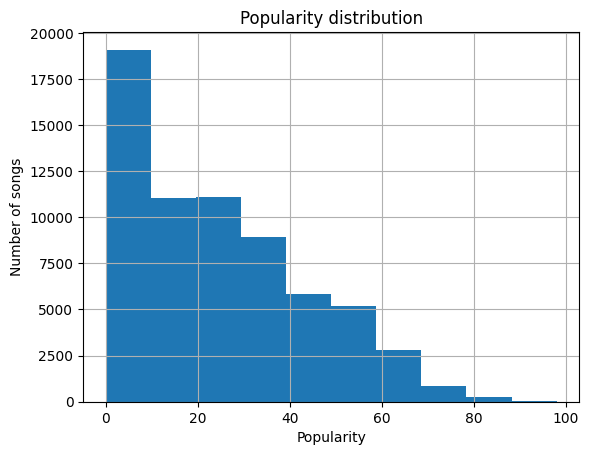

In [87]:
df["popularity"].hist()
plt.xlabel("Popularity")
plt.ylabel("Number of songs")
plt.title("Popularity distribution")

<Axes: >

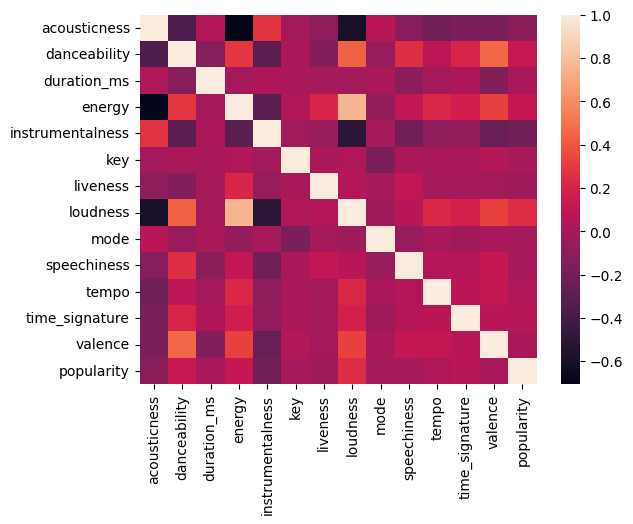

In [88]:
corr = df.corr()
sns.heatmap(corr)

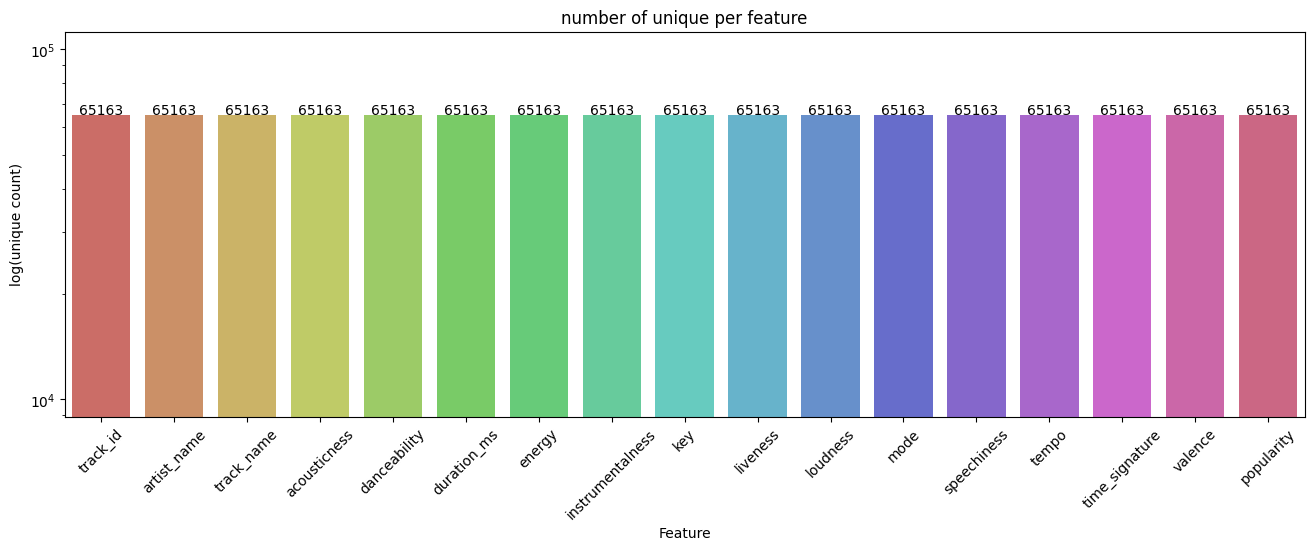

In [89]:
plt.figure(figsize = (16,5))
cols = df.columns
uniq = [len(df[col])for col in cols]
ax = sns.barplot(x = cols, y = uniq, palette = "hls", log = True)
ax.set(xlabel = "Feature", ylabel = "log(unique count)", title = "number of unique per feature")

for p, uniq in zip(ax.patches, uniq):
  ax.text(p.get_x() + p.get_width()/2,
  uniq +10,
  uniq,
  ha = "center")
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)


Text(0.5, 1.0, 'energy distribution')

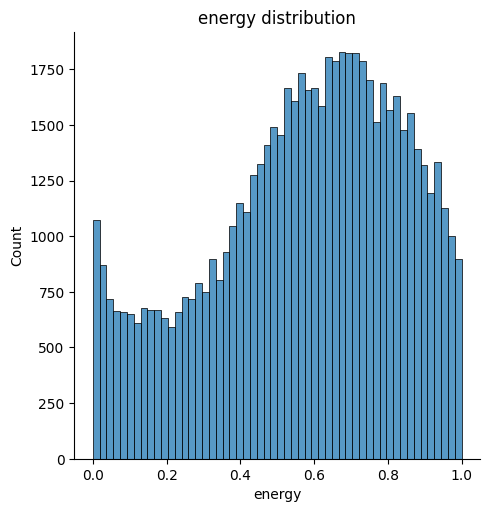

In [90]:
sns.displot(df["energy"])
plt.title("energy distribution")

Regression model with catboost

In [91]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['popularity']), 
    df['popularity'])


In [94]:
df.columns

Index(['track_id', 'artist_name', 'track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'popularity'],
      dtype='object')

In [95]:
from catboost import CatBoostRegressor, Pool
cat_features = ["track_id",'artist_name', 'key', 'time_signature',"track_name"]
X_train[cat_features] = X_train[cat_features].astype("str")
X_test[cat_features] = X_test[cat_features].astype("str")

In [100]:
train_dataset = Pool(X_train, y_train, cat_features = cat_features)
eval_dataset = Pool(X_test, y_test, cat_features = cat_features)
model = CatBoostRegressor(learning_rate = 0.1, iterations = 1000, eval_metric = "R2",metric_period = 50,
                          early_stopping_rounds = 20)

In [101]:
model.fit(train_dataset, eval_set = eval_dataset)

0:	learn: 0.0639707	test: 0.0785105	best: 0.0785105 (0)	total: 133ms	remaining: 2m 13s
50:	learn: 0.3866314	test: 0.4698774	best: 0.4698774 (50)	total: 4.18s	remaining: 1m 17s
100:	learn: 0.3989842	test: 0.4749536	best: 0.4749536 (100)	total: 9.7s	remaining: 1m 26s
150:	learn: 0.4100344	test: 0.4787215	best: 0.4787215 (150)	total: 14s	remaining: 1m 18s
200:	learn: 0.4181955	test: 0.4807956	best: 0.4808032 (195)	total: 18.2s	remaining: 1m 12s
250:	learn: 0.4245730	test: 0.4824677	best: 0.4824677 (250)	total: 23.7s	remaining: 1m 10s
300:	learn: 0.4300156	test: 0.4833206	best: 0.4833257 (299)	total: 27.7s	remaining: 1m 4s
350:	learn: 0.4352723	test: 0.4840625	best: 0.4840625 (350)	total: 31.9s	remaining: 59s
400:	learn: 0.4403470	test: 0.4845044	best: 0.4845190 (394)	total: 37.5s	remaining: 56s
450:	learn: 0.4445579	test: 0.4848896	best: 0.4848896 (450)	total: 41.8s	remaining: 50.9s
500:	learn: 0.4490164	test: 0.4851155	best: 0.4851226 (497)	total: 47.1s	remaining: 46.9s
550:	learn: 0.453

In [102]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.0 MB/s eta 0:00:00


In [103]:
import shap

In [111]:
explainer = shap.Explainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_train)

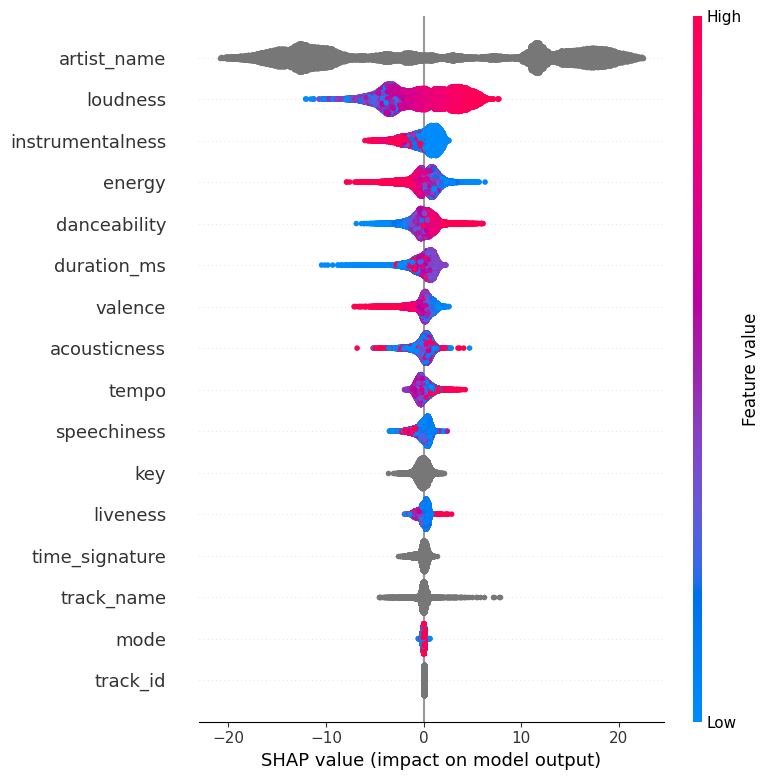

In [112]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

Let's optimize hyperparameters with optuna 

In [113]:
!pip install optuna 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [125]:
import optuna 
def objective(trial):
  params = {
      
       "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3, step = 0.05),

       "max_depth": trial.suggest_int("max_depth", 5, 15, step=2)
  }
  cat_reg = CatBoostRegressor(**params,iterations = 1000, eval_metric = "R2",metric_period = 50,
                          early_stopping_rounds = 20)
  cat_reg.fit(train_dataset, eval_set = eval_dataset)
  result = model.eval_metrics(eval_dataset, metrics = "R2")
  return result
  

In [126]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=50)

[I 2023-05-02 15:16:42,988] A new study created in memory with name: no-name-8206b449-f93a-4011-9fd1-d55048562b23


0:	learn: 0.1495077	test: 0.1877656	best: 0.1877656 (0)	total: 127ms	remaining: 2m 7s
50:	learn: 0.4412460	test: 0.4776716	best: 0.4776716 (50)	total: 9.43s	remaining: 2m 55s
100:	learn: 0.4857335	test: 0.4799696	best: 0.4800595 (80)	total: 19.1s	remaining: 2m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4800594599
bestIteration = 80

Shrink model to first 81 iterations.


[W 2023-05-02 15:17:08,375] Trial 0 failed with parameters: {'learning_rate': 0.25, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0965750	test: 0.1182642	best: 0.1182642 (0)	total: 2.54s	remaining: 42m 13s
50:	learn: 0.6047200	test: 0.4700869	best: 0.4703836 (32)	total: 2m 6s	remaining: 39m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.470383565
bestIteration = 32

Shrink model to first 33 iterations.


[W 2023-05-02 15:19:26,382] Trial 1 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 15} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.46726055089261

0:	learn: 0.1767018	test: 0.2203858	best: 0.2203858 (0)	total: 224ms	remaining: 3m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4749848398
bestIteration = 21

Shrink model to first 22 iterations.


[W 2023-05-02 15:19:45,239] Trial 2 failed with parameters: {'learning_rate': 0.3, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1246936	test: 0.1554887	best: 0.1554887 (0)	total: 281ms	remaining: 4m 40s
50:	learn: 0.4745500	test: 0.4779631	best: 0.4779631 (50)	total: 15.6s	remaining: 4m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.47853128
bestIteration = 52

Shrink model to first 53 iterations.


[W 2023-05-02 15:20:13,669] Trial 3 failed with parameters: {'learning_rate': 0.2, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0933246	test: 0.1146751	best: 0.1146751 (0)	total: 62.1ms	remaining: 1m 2s
50:	learn: 0.3876887	test: 0.4692530	best: 0.4692530 (50)	total: 3.11s	remaining: 57.9s
100:	learn: 0.4012841	test: 0.4748600	best: 0.4748600 (100)	total: 6.59s	remaining: 58.6s
150:	learn: 0.4103755	test: 0.4777785	best: 0.4777785 (150)	total: 11.5s	remaining: 1m 4s
200:	learn: 0.4168155	test: 0.4798225	best: 0.4798330 (199)	total: 14.8s	remaining: 58.7s
250:	learn: 0.4234421	test: 0.4811846	best: 0.4812478 (247)	total: 18.2s	remaining: 54.2s
300:	learn: 0.4284604	test: 0.4822186	best: 0.4822418 (298)	total: 21.6s	remaining: 50.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4826004363
bestIteration = 312

Shrink model to first 313 iterations.


[W 2023-05-02 15:20:44,667] Trial 4 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 5} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617

0:	learn: 0.1768761	test: 0.2197499	best: 0.2197499 (0)	total: 543ms	remaining: 9m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4685297419
bestIteration = 23

Shrink model to first 24 iterations.


[W 2023-05-02 15:21:20,363] Trial 5 failed with parameters: {'learning_rate': 0.3, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0658279	test: 0.0817293	best: 0.0817293 (0)	total: 666ms	remaining: 11m 4s
50:	learn: 0.4733407	test: 0.4770135	best: 0.4770135 (50)	total: 36s	remaining: 11m 10s
100:	learn: 0.5418666	test: 0.4805436	best: 0.4805800 (98)	total: 1m 11s	remaining: 10m 36s
150:	learn: 0.6069617	test: 0.4814067	best: 0.4817250 (146)	total: 1m 48s	remaining: 10m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4817250163
bestIteration = 146

Shrink model to first 147 iterations.


[W 2023-05-02 15:23:26,997] Trial 6 failed with parameters: {'learning_rate': 0.1, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0961049	test: 0.1198123	best: 0.1198123 (0)	total: 234ms	remaining: 3m 53s
50:	learn: 0.4523594	test: 0.4764254	best: 0.4764254 (50)	total: 15.1s	remaining: 4m 41s
100:	learn: 0.5109249	test: 0.4796391	best: 0.4796883 (91)	total: 32.5s	remaining: 4m 48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4798278187
bestIteration = 103

Shrink model to first 104 iterations.


[W 2023-05-02 15:24:12,794] Trial 7 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.46726055089261

0:	learn: 0.1495077	test: 0.1877656	best: 0.1877656 (0)	total: 122ms	remaining: 2m 2s
50:	learn: 0.4412460	test: 0.4776716	best: 0.4776716 (50)	total: 8.64s	remaining: 2m 40s
100:	learn: 0.4857335	test: 0.4799696	best: 0.4800595 (80)	total: 19.3s	remaining: 2m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4800594599
bestIteration = 80

Shrink model to first 81 iterations.


[W 2023-05-02 15:24:38,259] Trial 8 failed with parameters: {'learning_rate': 0.25, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1516900	test: 0.1884565	best: 0.1884565 (0)	total: 536ms	remaining: 8m 55s
50:	learn: 0.5864505	test: 0.4677814	best: 0.4693309 (31)	total: 34.4s	remaining: 10m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4693308715
bestIteration = 31

Shrink model to first 32 iterations.


[W 2023-05-02 15:25:19,658] Trial 9 failed with parameters: {'learning_rate': 0.25, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1247866	test: 0.1550220	best: 0.1550220 (0)	total: 545ms	remaining: 9m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.472735314
bestIteration = 23

Shrink model to first 24 iterations.


[W 2023-05-02 15:25:56,288] Trial 10 failed with parameters: {'learning_rate': 0.2, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1524545	test: 0.1866378	best: 0.1866378 (0)	total: 3.07s	remaining: 51m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.46898785
bestIteration = 24

Shrink model to first 25 iterations.


[W 2023-05-02 15:28:00,834] Trial 11 failed with parameters: {'learning_rate': 0.25, 'max_depth': 15} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.467534748

0:	learn: 0.0640674	test: 0.0785621	best: 0.0785621 (0)	total: 87.2ms	remaining: 1m 27s
50:	learn: 0.3916254	test: 0.4710155	best: 0.4710479 (49)	total: 4.66s	remaining: 1m 26s
100:	learn: 0.4057908	test: 0.4765747	best: 0.4765747 (100)	total: 11.4s	remaining: 1m 41s
150:	learn: 0.4190725	test: 0.4807970	best: 0.4807970 (150)	total: 16.8s	remaining: 1m 34s
200:	learn: 0.4298741	test: 0.4829012	best: 0.4829450 (198)	total: 24.2s	remaining: 1m 36s
250:	learn: 0.4388641	test: 0.4841033	best: 0.4841705 (245)	total: 29.8s	remaining: 1m 29s
300:	learn: 0.4475274	test: 0.4848790	best: 0.4849289 (299)	total: 36.3s	remaining: 1m 24s
350:	learn: 0.4556701	test: 0.4852108	best: 0.4852695 (340)	total: 42.3s	remaining: 1m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4852695279
bestIteration = 340

Shrink model to first 341 iterations.


[W 2023-05-02 15:28:50,185] Trial 12 failed with parameters: {'learning_rate': 0.1, 'max_depth': 7} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1210717	test: 0.1489218	best: 0.1489218 (0)	total: 119ms	remaining: 1m 58s
50:	learn: 0.3924127	test: 0.4715700	best: 0.4715700 (50)	total: 3.79s	remaining: 1m 10s
100:	learn: 0.4068560	test: 0.4764374	best: 0.4765309 (99)	total: 7.41s	remaining: 1m 5s
150:	learn: 0.4160713	test: 0.4791861	best: 0.4791861 (150)	total: 10.8s	remaining: 1m
200:	learn: 0.4240721	test: 0.4805725	best: 0.4806740 (198)	total: 15.9s	remaining: 1m 3s
250:	learn: 0.4303344	test: 0.4812770	best: 0.4813478 (247)	total: 19.4s	remaining: 57.9s
300:	learn: 0.4358252	test: 0.4819016	best: 0.4819672 (297)	total: 22.9s	remaining: 53.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4819672156
bestIteration = 297

Shrink model to first 298 iterations.


[W 2023-05-02 15:29:20,642] Trial 13 failed with parameters: {'learning_rate': 0.2, 'max_depth': 5} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1471382	test: 0.1811581	best: 0.1811581 (0)	total: 60.6ms	remaining: 1m
50:	learn: 0.3963230	test: 0.4726565	best: 0.4726599 (49)	total: 3.2s	remaining: 59.6s
100:	learn: 0.4117743	test: 0.4776979	best: 0.4776979 (100)	total: 6.57s	remaining: 58.5s
150:	learn: 0.4216576	test: 0.4797790	best: 0.4797790 (150)	total: 11.5s	remaining: 1m 4s
200:	learn: 0.4297296	test: 0.4806235	best: 0.4806235 (200)	total: 14.8s	remaining: 59s
250:	learn: 0.4375768	test: 0.4812154	best: 0.4812383 (238)	total: 18.3s	remaining: 54.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4812382545
bestIteration = 238

Shrink model to first 239 iterations.


[W 2023-05-02 15:29:45,686] Trial 14 failed with parameters: {'learning_rate': 0.25, 'max_depth': 5} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.0660840	test: 0.0809110	best: 0.0809110 (0)	total: 2.39s	remaining: 39m 47s
50:	learn: 0.5446238	test: 0.4714520	best: 0.4718930 (43)	total: 2m 1s	remaining: 37m 47s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4723031782
bestIteration = 64

Shrink model to first 65 iterations.


[W 2023-05-02 15:33:18,377] Trial 15 failed with parameters: {'learning_rate': 0.1, 'max_depth': 15} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1230186	test: 0.1544575	best: 0.1544575 (0)	total: 235ms	remaining: 3m 55s
50:	learn: 0.4304162	test: 0.4775605	best: 0.4775605 (50)	total: 9.06s	remaining: 2m 48s
100:	learn: 0.4689669	test: 0.4802022	best: 0.4803290 (91)	total: 19.4s	remaining: 2m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808229816
bestIteration = 121

Shrink model to first 122 iterations.


[W 2023-05-02 15:33:52,095] Trial 16 failed with parameters: {'learning_rate': 0.2, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0948232	test: 0.1190140	best: 0.1190140 (0)	total: 119ms	remaining: 1m 59s
50:	learn: 0.4184660	test: 0.4761883	best: 0.4761883 (50)	total: 9.58s	remaining: 2m 58s
100:	learn: 0.4505650	test: 0.4812528	best: 0.4812528 (100)	total: 19.8s	remaining: 2m 56s
150:	learn: 0.4806575	test: 0.4830426	best: 0.4831941 (142)	total: 28.9s	remaining: 2m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4831940967
bestIteration = 142

Shrink model to first 143 iterations.


[W 2023-05-02 15:34:29,717] Trial 17 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.46726055089261

0:	learn: 0.0640674	test: 0.0785621	best: 0.0785621 (0)	total: 86.3ms	remaining: 1m 26s
50:	learn: 0.3916254	test: 0.4710155	best: 0.4710479 (49)	total: 4.59s	remaining: 1m 25s
100:	learn: 0.4057908	test: 0.4765747	best: 0.4765747 (100)	total: 11.2s	remaining: 1m 39s
150:	learn: 0.4190725	test: 0.4807970	best: 0.4807970 (150)	total: 16.5s	remaining: 1m 32s
200:	learn: 0.4298741	test: 0.4829012	best: 0.4829450 (198)	total: 23.5s	remaining: 1m 33s
250:	learn: 0.4388641	test: 0.4841033	best: 0.4841705 (245)	total: 28.9s	remaining: 1m 26s
300:	learn: 0.4475274	test: 0.4848790	best: 0.4849289 (299)	total: 35.9s	remaining: 1m 23s
350:	learn: 0.4556701	test: 0.4852108	best: 0.4852695 (340)	total: 41.2s	remaining: 1m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4852695279
bestIteration = 340

Shrink model to first 341 iterations.


[W 2023-05-02 15:35:18,099] Trial 18 failed with parameters: {'learning_rate': 0.1, 'max_depth': 7} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0658279	test: 0.0817293	best: 0.0817293 (0)	total: 549ms	remaining: 9m 8s
50:	learn: 0.4733407	test: 0.4770135	best: 0.4770135 (50)	total: 30.3s	remaining: 9m 24s
100:	learn: 0.5418666	test: 0.4805436	best: 0.4805800 (98)	total: 1m 1s	remaining: 9m 11s
150:	learn: 0.6069617	test: 0.4814067	best: 0.4817250 (146)	total: 1m 37s	remaining: 9m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4817250163
bestIteration = 146

Shrink model to first 147 iterations.


[W 2023-05-02 15:37:13,076] Trial 19 failed with parameters: {'learning_rate': 0.1, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.0640674	test: 0.0785621	best: 0.0785621 (0)	total: 86.1ms	remaining: 1m 26s
50:	learn: 0.3916254	test: 0.4710155	best: 0.4710479 (49)	total: 6.27s	remaining: 1m 56s
100:	learn: 0.4057908	test: 0.4765747	best: 0.4765747 (100)	total: 11.5s	remaining: 1m 42s
150:	learn: 0.4190725	test: 0.4807970	best: 0.4807970 (150)	total: 18.4s	remaining: 1m 43s
200:	learn: 0.4298741	test: 0.4829012	best: 0.4829450 (198)	total: 24s	remaining: 1m 35s
250:	learn: 0.4388641	test: 0.4841033	best: 0.4841705 (245)	total: 31s	remaining: 1m 32s
300:	learn: 0.4475274	test: 0.4848790	best: 0.4849289 (299)	total: 36.7s	remaining: 1m 25s
350:	learn: 0.4556701	test: 0.4852108	best: 0.4852695 (340)	total: 43.3s	remaining: 1m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4852695279
bestIteration = 340

Shrink model to first 341 iterations.


[W 2023-05-02 15:38:04,233] Trial 20 failed with parameters: {'learning_rate': 0.1, 'max_depth': 7} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0961659	test: 0.1194462	best: 0.1194462 (0)	total: 548ms	remaining: 9m 7s
50:	learn: 0.5161854	test: 0.4752665	best: 0.4752665 (50)	total: 33.6s	remaining: 10m 25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4767301956
bestIteration = 77

Shrink model to first 78 iterations.


[W 2023-05-02 15:39:15,785] Trial 21 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.4672605508926

0:	learn: 0.0640674	test: 0.0785621	best: 0.0785621 (0)	total: 160ms	remaining: 2m 39s
50:	learn: 0.3916254	test: 0.4710155	best: 0.4710479 (49)	total: 5.24s	remaining: 1m 37s
100:	learn: 0.4057908	test: 0.4765747	best: 0.4765747 (100)	total: 10.5s	remaining: 1m 33s
150:	learn: 0.4190725	test: 0.4807970	best: 0.4807970 (150)	total: 17.4s	remaining: 1m 37s
200:	learn: 0.4298741	test: 0.4829012	best: 0.4829450 (198)	total: 23.2s	remaining: 1m 32s
250:	learn: 0.4388641	test: 0.4841033	best: 0.4841705 (245)	total: 30.3s	remaining: 1m 30s
300:	learn: 0.4475274	test: 0.4848790	best: 0.4849289 (299)	total: 35.9s	remaining: 1m 23s
350:	learn: 0.4556701	test: 0.4852108	best: 0.4852695 (340)	total: 42.8s	remaining: 1m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4852695279
bestIteration = 340

Shrink model to first 341 iterations.


[W 2023-05-02 15:40:05,834] Trial 22 failed with parameters: {'learning_rate': 0.1, 'max_depth': 7} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1210717	test: 0.1489218	best: 0.1489218 (0)	total: 61.7ms	remaining: 1m 1s
50:	learn: 0.3924127	test: 0.4715700	best: 0.4715700 (50)	total: 4.76s	remaining: 1m 28s
100:	learn: 0.4068560	test: 0.4764374	best: 0.4765309 (99)	total: 8.2s	remaining: 1m 12s
150:	learn: 0.4160713	test: 0.4791861	best: 0.4791861 (150)	total: 11.5s	remaining: 1m 4s
200:	learn: 0.4240721	test: 0.4805725	best: 0.4806740 (198)	total: 15.7s	remaining: 1m 2s
250:	learn: 0.4303344	test: 0.4812770	best: 0.4813478 (247)	total: 20s	remaining: 59.6s
300:	learn: 0.4358252	test: 0.4819016	best: 0.4819672 (297)	total: 23.4s	remaining: 54.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4819672156
bestIteration = 297

Shrink model to first 298 iterations.


[W 2023-05-02 15:40:36,647] Trial 23 failed with parameters: {'learning_rate': 0.2, 'max_depth': 5} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0961049	test: 0.1198123	best: 0.1198123 (0)	total: 247ms	remaining: 4m 6s
50:	learn: 0.4523594	test: 0.4764254	best: 0.4764254 (50)	total: 15.1s	remaining: 4m 40s
100:	learn: 0.5109249	test: 0.4796391	best: 0.4796883 (91)	total: 30.7s	remaining: 4m 33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4798278187
bestIteration = 103

Shrink model to first 104 iterations.


[W 2023-05-02 15:41:21,415] Trial 24 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.4672605508926

0:	learn: 0.1247866	test: 0.1550220	best: 0.1550220 (0)	total: 538ms	remaining: 8m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.472735314
bestIteration = 23

Shrink model to first 24 iterations.


[W 2023-05-02 15:41:56,816] Trial 25 failed with parameters: {'learning_rate': 0.2, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1742907	test: 0.2189385	best: 0.2189385 (0)	total: 129ms	remaining: 2m 8s
50:	learn: 0.4502153	test: 0.4772998	best: 0.4775055 (48)	total: 9.82s	remaining: 3m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4796081027
bestIteration = 71

Shrink model to first 72 iterations.


[W 2023-05-02 15:42:21,302] Trial 26 failed with parameters: {'learning_rate': 0.3, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.0961659	test: 0.1194462	best: 0.1194462 (0)	total: 548ms	remaining: 9m 7s
50:	learn: 0.5161854	test: 0.4752665	best: 0.4752665 (50)	total: 32s	remaining: 9m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4767301956
bestIteration = 77

Shrink model to first 78 iterations.


[W 2023-05-02 15:43:32,481] Trial 27 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.4672605508926

0:	learn: 0.1515593	test: 0.1890132	best: 0.1890132 (0)	total: 222ms	remaining: 3m 41s
50:	learn: 0.5022314	test: 0.4728326	best: 0.4737201 (32)	total: 16s	remaining: 4m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4737201119
bestIteration = 32

Shrink model to first 33 iterations.


[W 2023-05-02 15:43:55,541] Trial 28 failed with parameters: {'learning_rate': 0.25, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.467534748

0:	learn: 0.1247866	test: 0.1550220	best: 0.1550220 (0)	total: 579ms	remaining: 9m 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.472735314
bestIteration = 23

Shrink model to first 24 iterations.


[W 2023-05-02 15:44:30,337] Trial 29 failed with parameters: {'learning_rate': 0.2, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.0948232	test: 0.1190140	best: 0.1190140 (0)	total: 127ms	remaining: 2m 6s
50:	learn: 0.4184660	test: 0.4761883	best: 0.4761883 (50)	total: 9.64s	remaining: 2m 59s
100:	learn: 0.4505650	test: 0.4812528	best: 0.4812528 (100)	total: 20s	remaining: 2m 57s
150:	learn: 0.4806575	test: 0.4830426	best: 0.4831941 (142)	total: 29.5s	remaining: 2m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4831940967
bestIteration = 142

Shrink model to first 143 iterations.


[W 2023-05-02 15:45:08,831] Trial 30 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.46726055089261

0:	learn: 0.1475359	test: 0.1814804	best: 0.1814804 (0)	total: 85.7ms	remaining: 1m 25s
50:	learn: 0.4122154	test: 0.4775621	best: 0.4775621 (50)	total: 6.57s	remaining: 2m 2s
100:	learn: 0.4383036	test: 0.4814442	best: 0.4815713 (98)	total: 12s	remaining: 1m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4818601712
bestIteration = 113

Shrink model to first 114 iterations.


[W 2023-05-02 15:45:30,814] Trial 31 failed with parameters: {'learning_rate': 0.25, 'max_depth': 7} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1230186	test: 0.1544575	best: 0.1544575 (0)	total: 129ms	remaining: 2m 9s
50:	learn: 0.4304162	test: 0.4775605	best: 0.4775605 (50)	total: 9.9s	remaining: 3m 4s
100:	learn: 0.4689669	test: 0.4802022	best: 0.4803290 (91)	total: 19.2s	remaining: 2m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808229816
bestIteration = 121

Shrink model to first 122 iterations.


[W 2023-05-02 15:46:04,381] Trial 32 failed with parameters: {'learning_rate': 0.2, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1524545	test: 0.1866378	best: 0.1866378 (0)	total: 3.77s	remaining: 1h 2m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.46898785
bestIteration = 24

Shrink model to first 25 iterations.


[W 2023-05-02 15:48:02,156] Trial 33 failed with parameters: {'learning_rate': 0.25, 'max_depth': 15} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.467534748

0:	learn: 0.0948232	test: 0.1190140	best: 0.1190140 (0)	total: 122ms	remaining: 2m 1s
50:	learn: 0.4184660	test: 0.4761883	best: 0.4761883 (50)	total: 9.66s	remaining: 2m 59s
100:	learn: 0.4505650	test: 0.4812528	best: 0.4812528 (100)	total: 20s	remaining: 2m 57s
150:	learn: 0.4806575	test: 0.4830426	best: 0.4831941 (142)	total: 28.9s	remaining: 2m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4831940967
bestIteration = 142

Shrink model to first 143 iterations.


[W 2023-05-02 15:48:40,341] Trial 34 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.46726055089261

0:	learn: 0.0948232	test: 0.1190140	best: 0.1190140 (0)	total: 121ms	remaining: 2m
50:	learn: 0.4184660	test: 0.4761883	best: 0.4761883 (50)	total: 9.61s	remaining: 2m 58s
100:	learn: 0.4505650	test: 0.4812528	best: 0.4812528 (100)	total: 21.4s	remaining: 3m 10s
150:	learn: 0.4806575	test: 0.4830426	best: 0.4831941 (142)	total: 30.5s	remaining: 2m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4831940967
bestIteration = 142

Shrink model to first 143 iterations.


[W 2023-05-02 15:49:20,195] Trial 35 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.46726055089261

0:	learn: 0.1524545	test: 0.1866378	best: 0.1866378 (0)	total: 2.32s	remaining: 38m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.46898785
bestIteration = 24

Shrink model to first 25 iterations.


[W 2023-05-02 15:51:18,044] Trial 36 failed with parameters: {'learning_rate': 0.25, 'max_depth': 15} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.467534748

0:	learn: 0.1715242	test: 0.2113839	best: 0.2113839 (0)	total: 61.5ms	remaining: 1m 1s
50:	learn: 0.3990587	test: 0.4741363	best: 0.4741363 (50)	total: 3.19s	remaining: 59.3s
100:	learn: 0.4153290	test: 0.4781951	best: 0.4781951 (100)	total: 6.9s	remaining: 1m 1s
150:	learn: 0.4270624	test: 0.4794266	best: 0.4800169 (140)	total: 11.5s	remaining: 1m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.480016854
bestIteration = 140

Shrink model to first 141 iterations.


[W 2023-05-02 15:51:35,827] Trial 37 failed with parameters: {'learning_rate': 0.3, 'max_depth': 5} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1475359	test: 0.1814804	best: 0.1814804 (0)	total: 86.4ms	remaining: 1m 26s
50:	learn: 0.4122154	test: 0.4775621	best: 0.4775621 (50)	total: 6.55s	remaining: 2m 1s
100:	learn: 0.4383036	test: 0.4814442	best: 0.4815713 (98)	total: 12s	remaining: 1m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4818601712
bestIteration = 113

Shrink model to first 114 iterations.


[W 2023-05-02 15:51:58,073] Trial 38 failed with parameters: {'learning_rate': 0.25, 'max_depth': 7} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.0638970	test: 0.0784178	best: 0.0784178 (0)	total: 61.3ms	remaining: 1m 1s
50:	learn: 0.3806706	test: 0.4667918	best: 0.4667918 (50)	total: 2.76s	remaining: 51.3s
100:	learn: 0.3920970	test: 0.4729492	best: 0.4729492 (100)	total: 6.44s	remaining: 57.3s
150:	learn: 0.4013015	test: 0.4763216	best: 0.4763216 (150)	total: 11s	remaining: 1m 1s
200:	learn: 0.4081570	test: 0.4790597	best: 0.4790597 (200)	total: 14.3s	remaining: 56.8s
250:	learn: 0.4132137	test: 0.4805083	best: 0.4805083 (250)	total: 17.6s	remaining: 52.6s
300:	learn: 0.4174263	test: 0.4818495	best: 0.4818639 (299)	total: 22.4s	remaining: 52s
350:	learn: 0.4212535	test: 0.4824091	best: 0.4824091 (350)	total: 25.7s	remaining: 47.5s
400:	learn: 0.4250962	test: 0.4833613	best: 0.4834225 (396)	total: 29.1s	remaining: 43.5s
450:	learn: 0.4282507	test: 0.4838939	best: 0.4839299 (448)	total: 33.2s	remaining: 40.5s
500:	learn: 0.4315545	test: 0.4843439	best: 0.4843439 (500)	total: 37.5s	remaining: 37.3s
550:	learn: 0.43431

[W 2023-05-02 15:52:45,213] Trial 39 failed with parameters: {'learning_rate': 0.1, 'max_depth': 5} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1230186	test: 0.1544575	best: 0.1544575 (0)	total: 265ms	remaining: 4m 24s
50:	learn: 0.4304162	test: 0.4775605	best: 0.4775605 (50)	total: 9.11s	remaining: 2m 49s
100:	learn: 0.4689669	test: 0.4802022	best: 0.4803290 (91)	total: 19.4s	remaining: 2m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808229816
bestIteration = 121

Shrink model to first 122 iterations.


[W 2023-05-02 15:53:19,131] Trial 40 failed with parameters: {'learning_rate': 0.2, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

0:	learn: 0.1253651	test: 0.1535064	best: 0.1535064 (0)	total: 2.32s	remaining: 38m 40s
50:	learn: 0.6429621	test: 0.4697745	best: 0.4722760 (30)	total: 2m 5s	remaining: 38m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.472276009
bestIteration = 30

Shrink model to first 31 iterations.


[W 2023-05-02 15:55:31,085] Trial 41 failed with parameters: {'learning_rate': 0.2, 'max_depth': 15} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1767018	test: 0.2203858	best: 0.2203858 (0)	total: 237ms	remaining: 3m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4749848398
bestIteration = 21

Shrink model to first 22 iterations.


[W 2023-05-02 15:55:49,383] Trial 42 failed with parameters: {'learning_rate': 0.3, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1475359	test: 0.1814804	best: 0.1814804 (0)	total: 87.4ms	remaining: 1m 27s
50:	learn: 0.4122154	test: 0.4775621	best: 0.4775621 (50)	total: 6.59s	remaining: 2m 2s
100:	learn: 0.4383036	test: 0.4814442	best: 0.4815713 (98)	total: 12s	remaining: 1m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4818601712
bestIteration = 113

Shrink model to first 114 iterations.


[W 2023-05-02 15:56:11,969] Trial 43 failed with parameters: {'learning_rate': 0.25, 'max_depth': 7} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.4675347482

0:	learn: 0.1516900	test: 0.1884565	best: 0.1884565 (0)	total: 539ms	remaining: 8m 58s
50:	learn: 0.5864505	test: 0.4677814	best: 0.4693309 (31)	total: 35.1s	remaining: 10m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4693308715
bestIteration = 31

Shrink model to first 32 iterations.


[W 2023-05-02 15:56:53,219] Trial 44 failed with parameters: {'learning_rate': 0.25, 'max_depth': 13} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.467534748

0:	learn: 0.0948232	test: 0.1190140	best: 0.1190140 (0)	total: 124ms	remaining: 2m 4s
50:	learn: 0.4184660	test: 0.4761883	best: 0.4761883 (50)	total: 9.8s	remaining: 3m 2s
100:	learn: 0.4505650	test: 0.4812528	best: 0.4812528 (100)	total: 20.2s	remaining: 2m 59s
150:	learn: 0.4806575	test: 0.4830426	best: 0.4831941 (142)	total: 29.2s	remaining: 2m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4831940967
bestIteration = 142

Shrink model to first 143 iterations.


[W 2023-05-02 15:57:32,050] Trial 45 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.46726055089261

0:	learn: 0.1524545	test: 0.1866378	best: 0.1866378 (0)	total: 2.36s	remaining: 39m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.46898785
bestIteration = 24

Shrink model to first 25 iterations.


[W 2023-05-02 15:59:29,709] Trial 46 failed with parameters: {'learning_rate': 0.25, 'max_depth': 15} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.467534748

0:	learn: 0.0961049	test: 0.1198123	best: 0.1198123 (0)	total: 237ms	remaining: 3m 56s
50:	learn: 0.4523594	test: 0.4764254	best: 0.4764254 (50)	total: 15.9s	remaining: 4m 55s
100:	learn: 0.5109249	test: 0.4796391	best: 0.4796883 (91)	total: 31.7s	remaining: 4m 41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4798278187
bestIteration = 103

Shrink model to first 104 iterations.


[W 2023-05-02 16:00:14,960] Trial 47 failed with parameters: {'learning_rate': 0.15000000000000002, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.4672605508926

0:	learn: 0.1515593	test: 0.1890132	best: 0.1890132 (0)	total: 220ms	remaining: 3m 40s
50:	learn: 0.5022314	test: 0.4728326	best: 0.4737201 (32)	total: 16.5s	remaining: 5m 6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4737201119
bestIteration = 32

Shrink model to first 33 iterations.


[W 2023-05-02 16:00:37,745] Trial 48 failed with parameters: {'learning_rate': 0.25, 'max_depth': 11} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.467534748

0:	learn: 0.1230186	test: 0.1544575	best: 0.1544575 (0)	total: 123ms	remaining: 2m 2s
50:	learn: 0.4304162	test: 0.4775605	best: 0.4775605 (50)	total: 9.97s	remaining: 3m 5s
100:	learn: 0.4689669	test: 0.4802022	best: 0.4803290 (91)	total: 19.6s	remaining: 2m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808229816
bestIteration = 121

Shrink model to first 122 iterations.


[W 2023-05-02 16:01:11,568] Trial 49 failed with parameters: {'learning_rate': 0.2, 'max_depth': 9} because of the following error: The value {'R2': [0.07851051872164416, 0.14299915476812664, 0.19621999997512063, 0.23951726868381107, 0.2767437073646296, 0.30591661495499756, 0.3308230412919152, 0.3503211146541504, 0.3667527710708136, 0.38346146575308415, 0.39503626187286256, 0.40445807949878687, 0.41377218622911127, 0.42003850391192965, 0.42683306562101275, 0.43225399993727187, 0.4365198204923454, 0.4407386934017429, 0.44419607778921644, 0.44741681682542644, 0.4501397802189867, 0.45212647410371476, 0.4539050447459142, 0.45557204330652434, 0.4569428500138062, 0.4579242039112382, 0.4590835593468624, 0.46016568751567566, 0.4609394727142394, 0.461748559540911, 0.4625274791694479, 0.46318373470549856, 0.4638611045589335, 0.46447596713926753, 0.46522432884435383, 0.4655803063558285, 0.46616330579405907, 0.466467239379429, 0.4666606842858545, 0.466905763237644, 0.467260550892617, 0.46753474829

In [130]:
!gdown --fuzzy https://drive.google.com/file/d/153j1inP_L5bM2wEcH8l2rmqP_uR0vgqe/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=153j1inP_L5bM2wEcH8l2rmqP_uR0vgqe
To: /content/data_scoring.csv
100% 9.28M/9.28M [00:00<00:00, 90.9MB/s]


In [155]:
data_scoring = pd.read_csv('data_scoring.csv')
data_scoring.head()

,track_id,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,6D8WgDaIuyirn6egGauzVK,RITUAL,Love Me Back,0.498,0.745,178233,0.664,0.000008,1,0.0777,-4.280,1,0.0613,108.067,4,0.468
1,7ywsuXRTQ9xNKhZSmSD3Q0,Dalton Mauldin,Nights Without You,0.221,0.539,157751,0.536,0.000000,5,0.4940,-8.722,1,0.0552,183.784,4,0.725
2,1eoGO19WEflJbAV8BLebhr,Pandrezz,Orion,0.805,0.684,152000,0.255,0.790000,10,0.0884,-9.381,0,0.0445,84.226,4,0.330
3,3G79AJm9H5lKnngSgBT21L,Mc Davi,Ela Tá Que Tá,0.128,0.750,206829,0.418,0.000000,0,0.1280,-10.011,1,0.0496,123.007,4,0.253
4,2htWos5rGxFWSfLTyvpymm,G-Eazy,But A Dream - Alex Lustig Remix,0.401,0.563,198058,0.633,0.000000,5,0.1090,-6.252,0,0.2700,156.000,4,0.306


In [156]:
cat_features = ["track_id",'artist_name', 'key', 'time_signature',"track_name"]
data_scoring[cat_features] = data_scoring[cat_features].astype("str")


In [158]:
y_scoring = np.clip(model.predict(data_scoring), 0, 100)

In [144]:
submission = pd.Series(y_scoring, index=data_scoring.index, name='popularity')
submission.head()

0    30.652394
1    23.976295
2    42.197306
3    38.064988
4    50.093084
Name: popularity, dtype: float64